# Homework 2 - Geospatial Analysis

Kimberlee Wong

Github Repo: https://github.com/kimberleewong/eds296-HW2

### Import Libraries and Data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import intake

### Choose 2 Models

I am going to use CESM2, the Community Earth System Model version 2 and CMCC-ESM2, the second version of the CMCC Earth System Model. The latter models the climate and biosphere of Earth, while the former represents ice, land, ocean, and atmosphere processes created by the National Center for Atmospheric Research. For the future projections, I will be using SSP370 which is a high emissions situation.

In [ ]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon'

# variable_id: which climate variables do you want? Here we want surface air temperature
variable_id = ['tas']

In [13]:
# Historical CESM2
cesm2_hist = catalog.search(
    activity_id='CMIP',
    source_id='CESM2',
    experiment_id='historical',
    member_id='r10i1p1f1',
    table_id=table_id,
    variable_id=variable_id)

# CESM2 SSP370
cesm2_fut = catalog.search(
    activity_id='ScenarioMIP',
    source_id='CESM2',
    experiment_id='ssp370',
    member_id='r10i1p1f1',
    table_id=table_id,
    variable_id=variable_id
)

# Historical CMCC-ESM2
cmcc_hist = catalog.search(
    activity_id='CMIP',
    source_id='CMCC-ESM2',
    experiment_id='historical',
    member_id='r1i1p1f1',
    table_id=table_id,
    variable_id=variable_id
)

# CESM2 SSP370
cmcc_fut = catalog.search(
    activity_id='ScenarioMIP',
    source_id='CMCC-ESM2',
    experiment_id='ssp370',
    member_id='r1i1p1f1',
    table_id=table_id,
    variable_id=variable_id
)

In [14]:
# Check if search returned results
print(f"CESM2 historical results: {cesm2_hist.df.shape[0]}")
print(f"CESM2 future results: {cesm2_fut.df.shape[0]}")
print(f"CMCC historical results: {cmcc_hist.df.shape[0]}")
print(f"CMCC future results: {cmcc_fut.df.shape[0]}")

CESM2 historical results: 1
CESM2 future results: 1
CMCC historical results: 1
CMCC future results: 1


In [15]:
# Save results as xarray
hist_cesm2 = xr.open_zarr(cesm2_hist.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
future_cesm2 = xr.open_zarr(cesm2_fut.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
hist_cmcc = xr.open_zarr(cmcc_hist.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
future_cmcc = xr.open_zarr(cmcc_fut.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)

In [16]:
# Save results as xarray
hist_cesm2 = xr.open_zarr(cesm2_hist.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
future_cesm2 = xr.open_zarr(cesm2_fut.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
hist_cmcc = xr.open_zarr(cmcc_hist.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)
future_cmcc = xr.open_zarr(cmcc_fut.df.iloc[0]['zstore'], storage_options={'anon': True}, consolidated=True)

hist_cesm2['time'] = hist_cesm2.time.astype('datetime64[ns]')
future_cesm2['time'] = future_cesm2.time.astype('datetime64[ns]')
hist_cmcc['time'] = hist_cmcc.time.astype('datetime64[ns]')
future_cmcc['time'] = future_cmcc.time.astype('datetime64[ns]')

# Concatenate history and future together
cesm2_data = xr.concat([hist_cesm2, future_cesm2], dim="time")
cmcc_data = xr.concat([hist_cmcc, future_cmcc], dim="time")

### Region and Time Period of Interest

The region I am choosing to study is Sub-Saharan Africa. This region exhibits vast climatic diversity and is experiencing profound impacts of climate change. I also spent time in Cameroon last year for my undergraduate capstone, so it'd be cool to look at its region again. Key climate zones and impacts to consider:

The Sahel: This semi-arid zone is seeing increased desertification and erratic rainfall patterns, which exacerbate food insecurity and migration pressures.

Savannas and Grasslands: Shifting rainfall patterns are altering ecosystems and impacting agriculture, a cornerstone of the region's economy.

Rainforests in Central Africa: Critical carbon sinks like the Congo Basin are under threat from deforestation and warming temperatures, which could shift these forests from carbon sinks to carbon sources.

Coastal Areas: West African coastal cities such as Lagos and Accra face significant risks from rising sea levels and intensified tropical storms.

Highlands and Mountains: Areas like Ethiopia's highlands are experiencing changes in seasonal patterns, impacting water resources and agriculture.

For time periods:
- historical: 1975 - 2025
- future: 2026 - 2075

In [18]:
# Define min/max bounds for region of interest
region = [-20, 52, -35, 15]

# Time period of interest
per_early = [1975, 2025]
per_late = [2026, 2075]


In [19]:

# Select data within the ranges of years specified above

# CESM2 
# Early period
cesm2_early = cesm2_data.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))

# Late period
cesm2_late = cesm2_data.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

# CMCC-ESM2 
# Early period
cmcc_early = cmcc_data.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))

# Late period
cmcc_late = cmcc_data.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

In [20]:
# Calculate time averages and convert to Celsius

# CESM2
cesm2_early_annmn = cesm2_early.mean(dim="time") - 273.15
cesm2_late_annmn = cesm2_late.mean(dim="time") - 273.15

# CMCC-ESM2
cmcc_early_annmn = cmcc_early.mean(dim="time") - 273.15
cmcc_late_annmn = cmcc_late.mean(dim="time") - 273.15

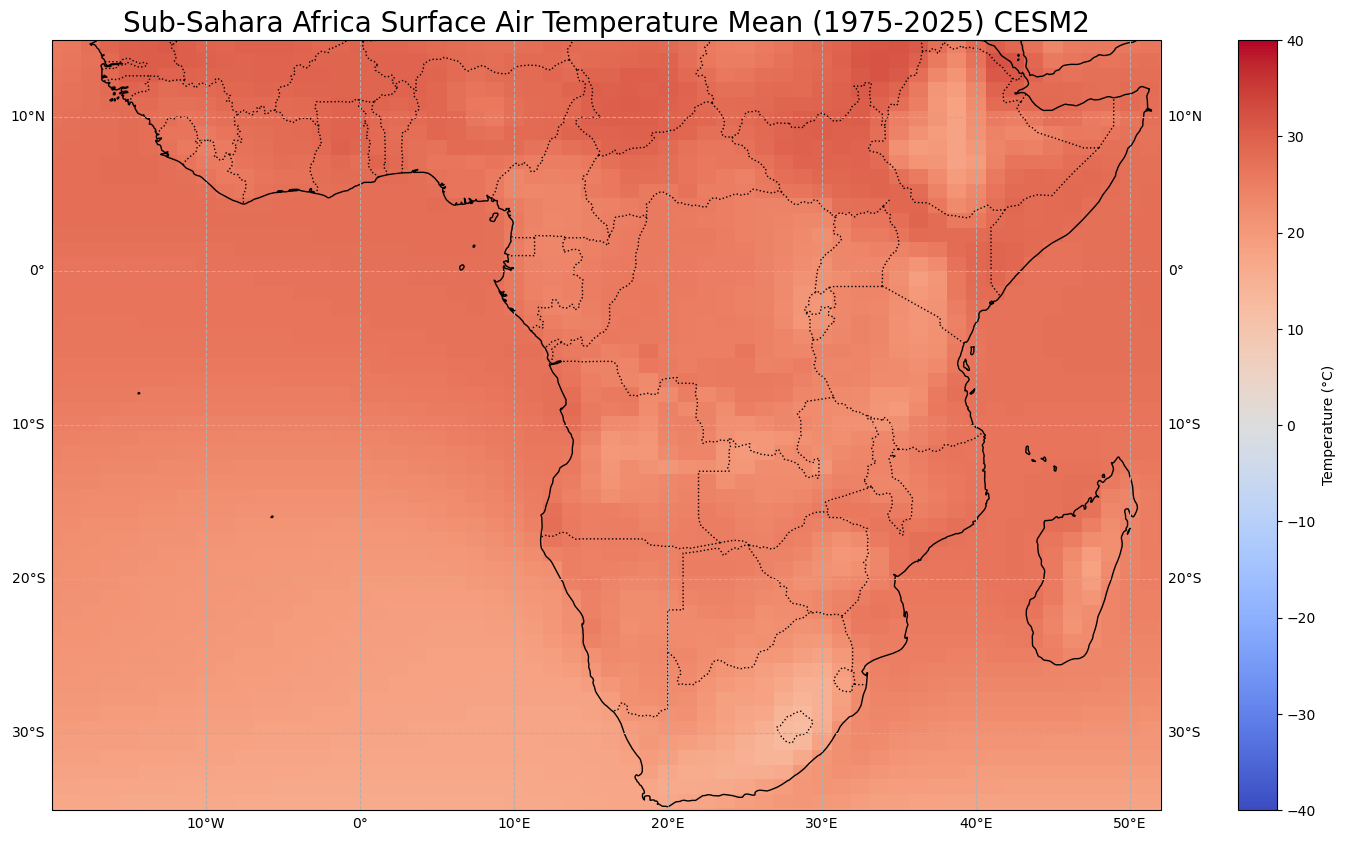

In [ ]:
# Plot CESM2 Model Historical

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(cesm2_early_annmn.lon, cesm2_early_annmn.lat, cesm2_early_annmn["tas"], transform=map, cmap="coolwarm", vmin=-40, vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Sub-Sahara Africa Surface Air Temperature Mean (1975-2025) CESM2", fontsize= 20)
plt.show()

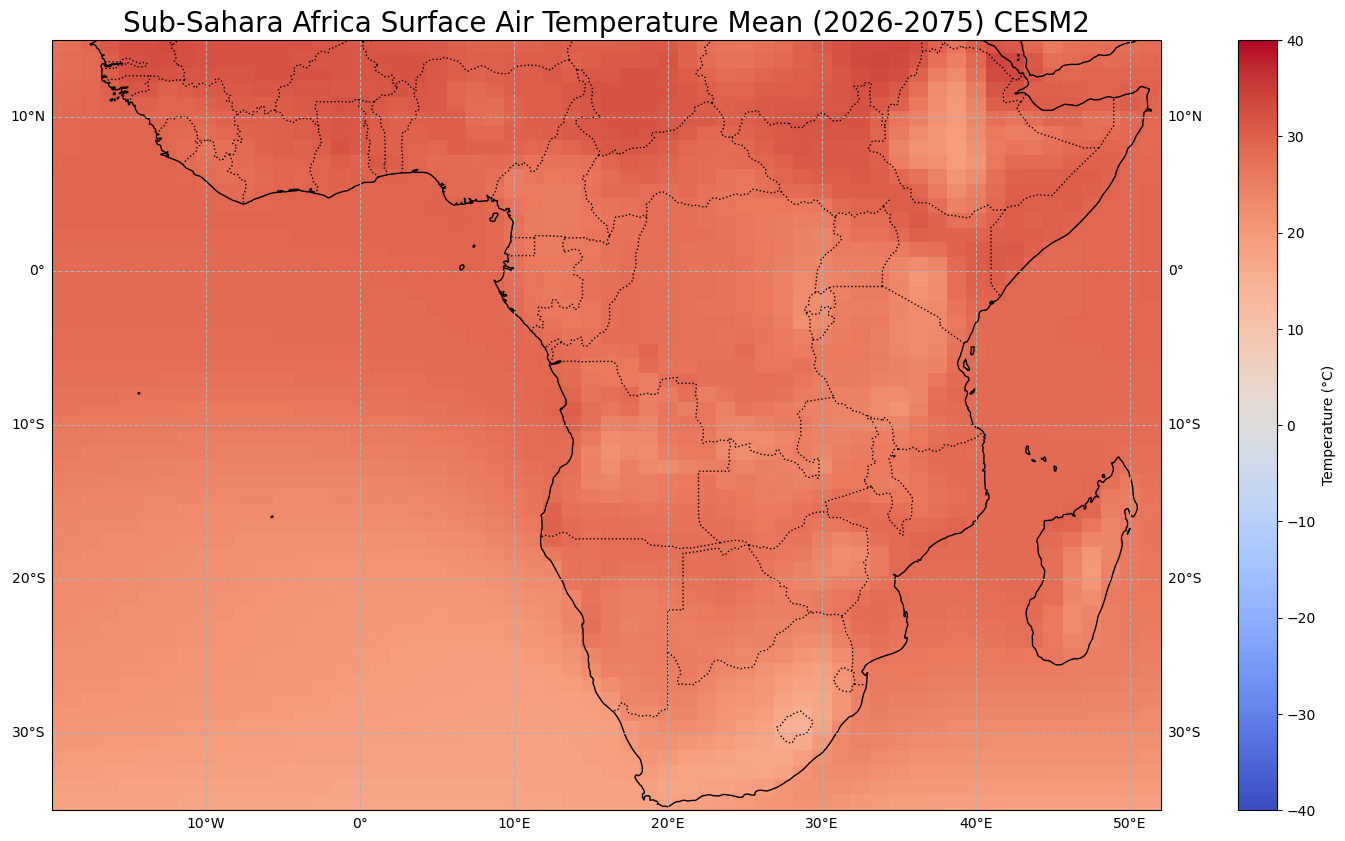

In [ ]:
# Plot CESM2 Model Future

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(cesm2_late_annmn.lon, cesm2_late_annmn.lat, cesm2_late_annmn["tas"], transform=map, cmap="coolwarm", vmin=-40, vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Sub-Sahara Africa Surface Air Temperature Mean (2026-2075) CESM2", fontsize= 20)
plt.show()

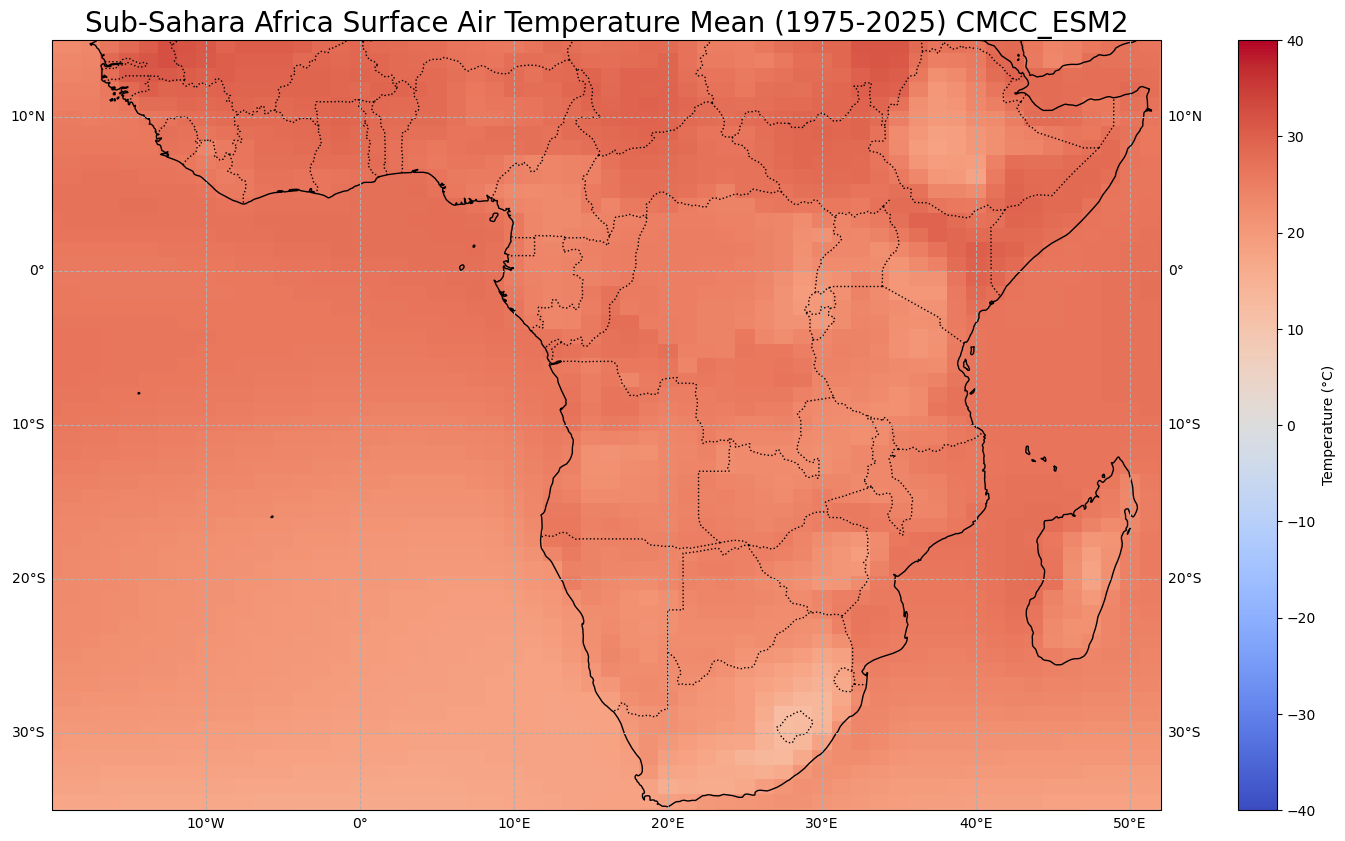

In [ ]:
# Plot CMCC-ESM2 Model Historical

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(cmcc_early_annmn.lon, cmcc_early_annmn.lat, cmcc_early_annmn["tas"], transform=map, cmap="coolwarm", vmin=-40, vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Sub-Sahara Africa Surface Air Temperature Mean (1975-2025) CMCC_ESM2", fontsize= 20)
plt.show()

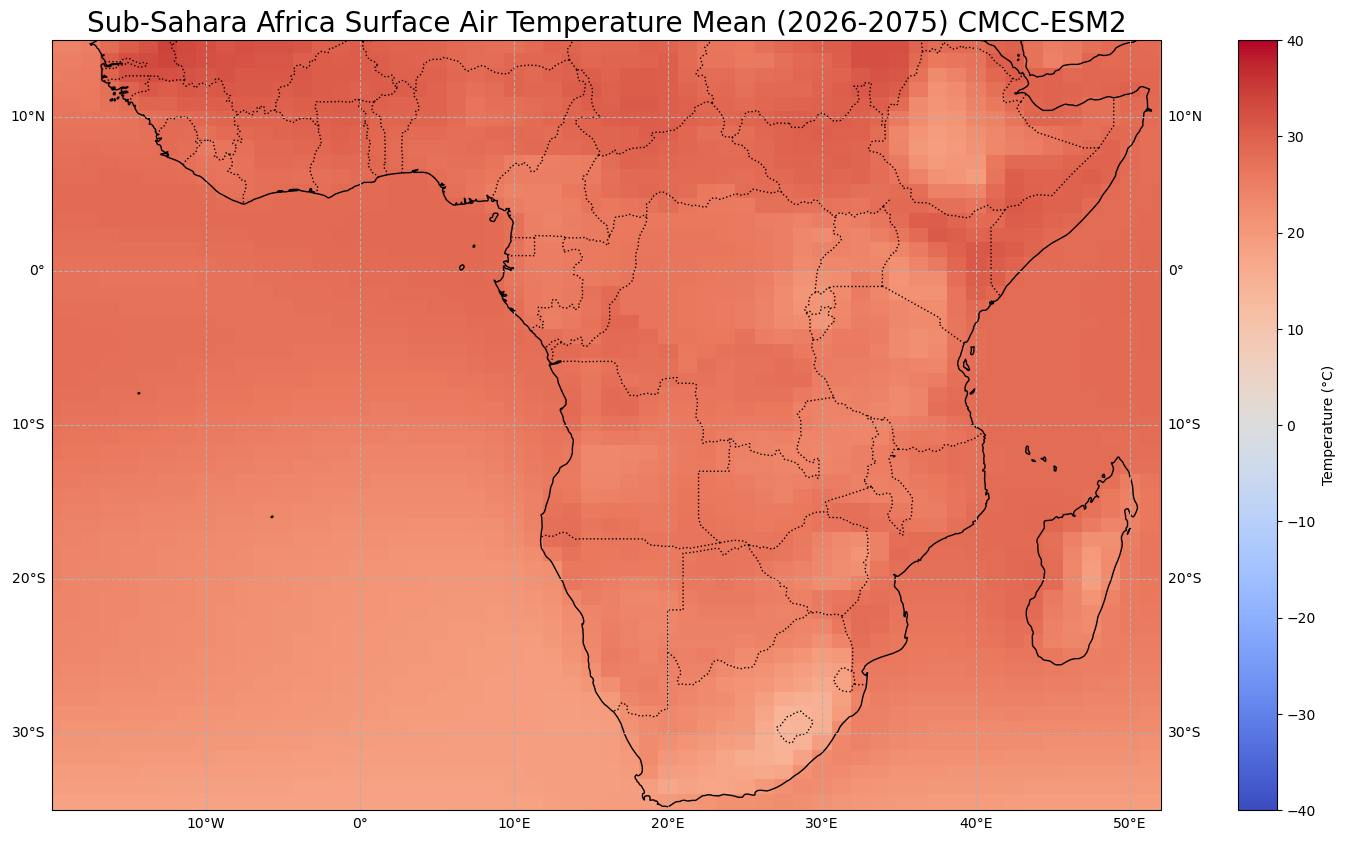

In [ ]:
# Plot CMCC-ESM2 Model Future

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(cmcc_late_annmn.lon, cmcc_late_annmn.lat, cmcc_late_annmn["tas"], transform=map, cmap="coolwarm", vmin=-40, vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Sub-Sahara Africa Surface Air Temperature Mean (2026-2075) CMCC-ESM2", fontsize= 20)
plt.show()

### Map Differences

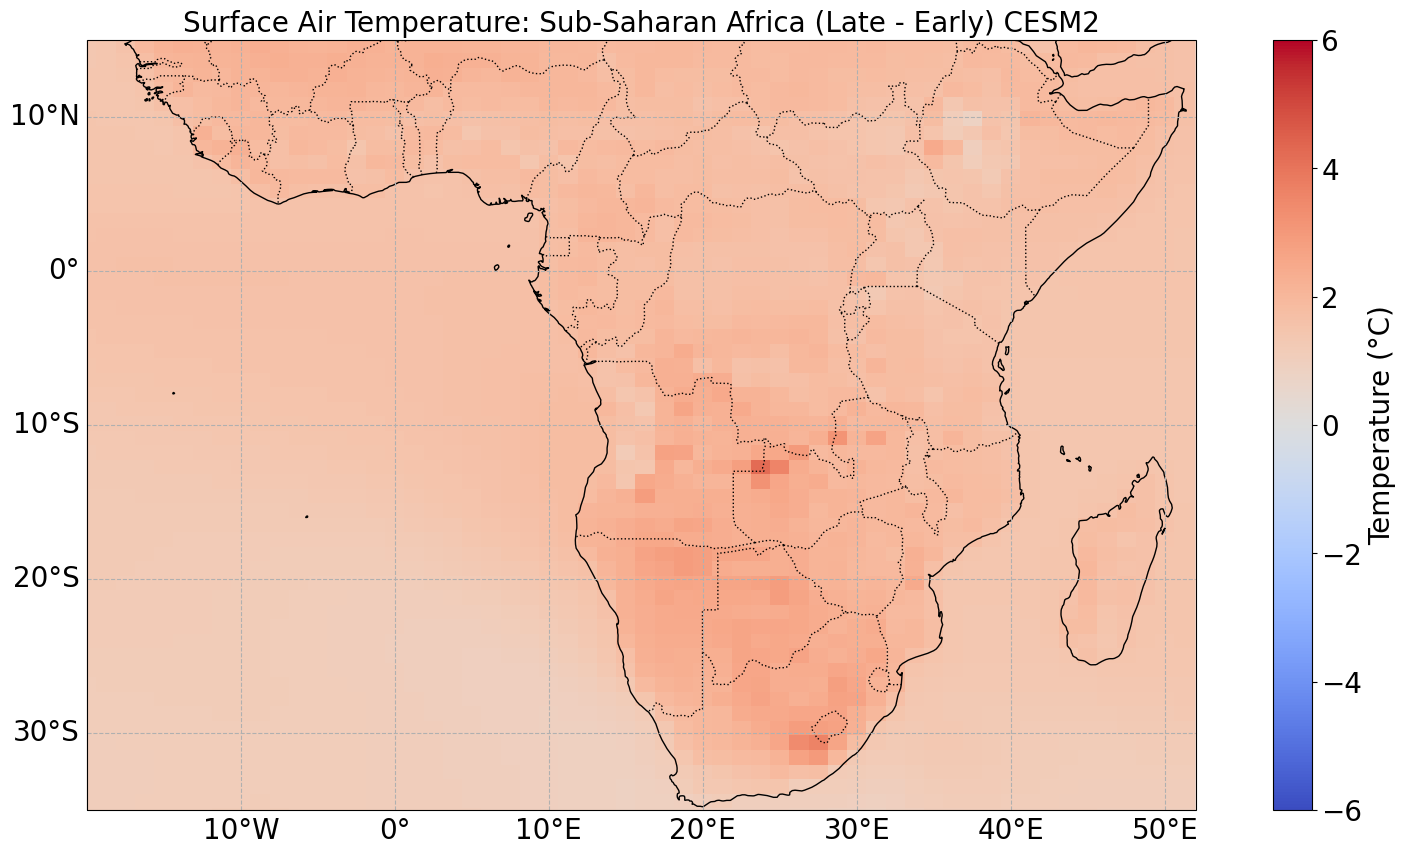

In [ ]:
# CESM2

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), 
                       subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(cesm2_late_annmn.lon, cesm2_late_annmn.lat, cesm2_late_annmn.tas - cesm2_early_annmn.tas, transform=map, cmap="coolwarm", vmin=-6, vmax=6)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("Surface Air Temperature: Sub-Saharan Africa (Late - Early) CESM2", fontsize= 20)
plt.show()

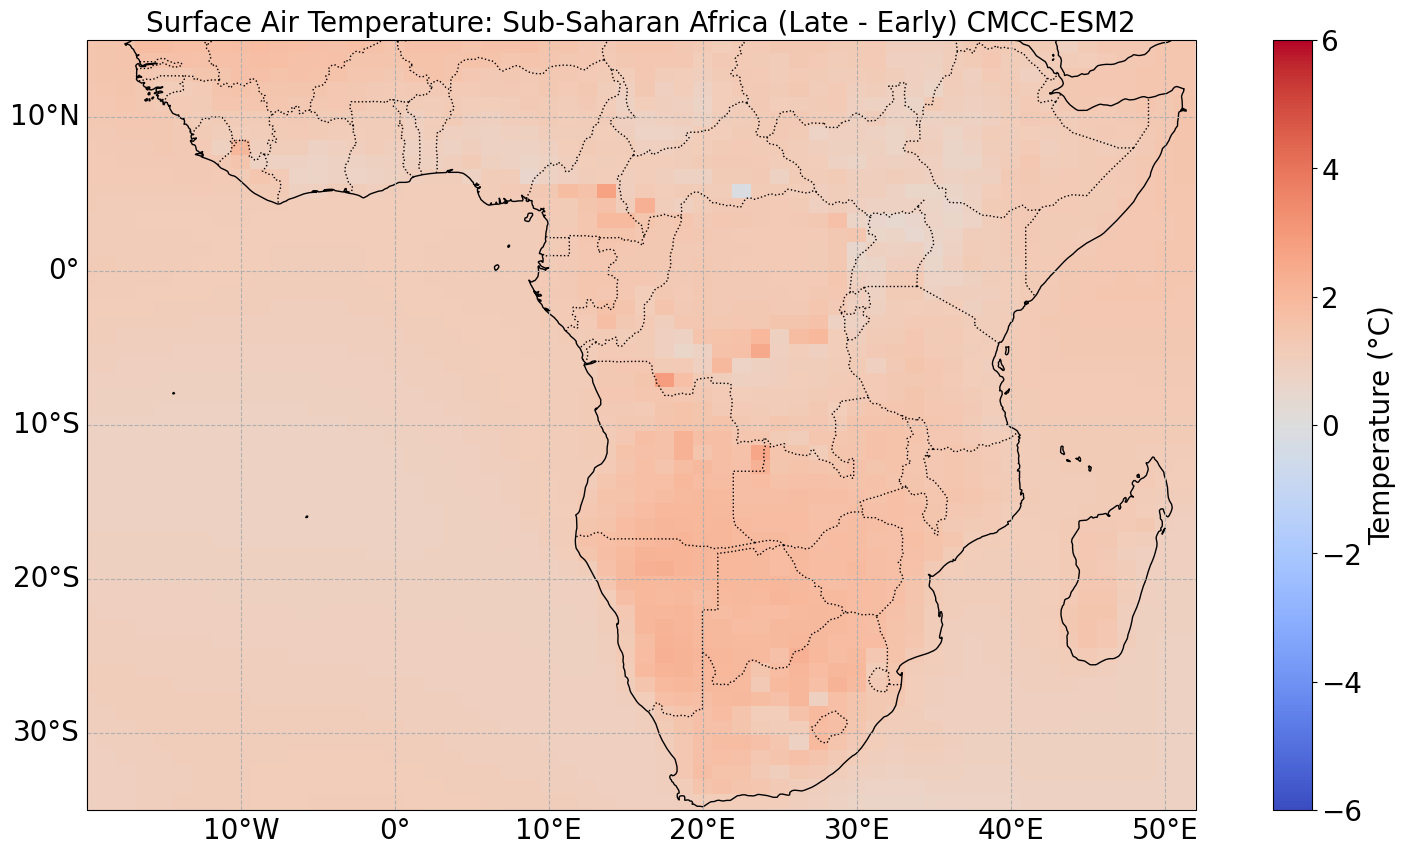

In [30]:
# CMCC-ESM2

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(cmcc_late_annmn.lon, cmcc_late_annmn.lat, cmcc_late_annmn.tas - cmcc_early_annmn.tas, transform=map, cmap="coolwarm", vmin=-6, vmax=6)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add title, show plot
ax.set_title("Surface Air Temperature: Sub-Saharan Africa (Late - Early) CMCC-ESM2", fontsize= 20)
plt.show()

### Results and Conclusion

Both the CMCC-ESM2 and CESM2 plots show projected changes in surface air temperature for Sub-Saharan Africa. Both maps show a consistent warming trend across the region, with temperature increases ranging between 2°C to 6°C compared to the baseline. The most pronounced warming appears in the southern and eastern parts of the region, especially in areas such as Southern Africa and parts of the Horn of Africa.

This significant warming poses challenges for human populations and ecosystems. Elevated temperatures may exacerbate water scarcity, leading to heightened stress on agricultural systems and food security. Ecosystems, particularly in savannas and rainforests, could face shifts in species composition and biodiversity loss. Additionally, increased heat extremes may worsen health outcomes, especially in vulnerable communities without adequate infrastructure to adapt to these changes.